# Interpreting a DQN trained on Connect 4
This blog post is an experiment into using gradient based interpretability methods to interpret Deep Q Networks. We train our model in the [ConnectX Kaggle environment](https://www.kaggle.com/c/connectx).

In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, Dropout, Input, concatenate

# Defining the Evironment and Agent Classes
This code is adapted from [Phung Hieu's Kaggle notebook](https://www.kaggle.com/phunghieu/connectx-with-q-learning) which in turn is adapted from [Siwei Xu's Towards Data Science article](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998).

In [23]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)


class DQN:
    def __init__(self, input_x, input_y, num_actions, 
                 gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        
        input_shape = Input(shape=(input_y, input_x, 1), name='7x6')

        tower_1 = Conv2D(20, (1, 1), padding='same', activation='relu', name='1x1')(input_shape)

        tower_2 = Conv2D(20, (1, input_y), padding='same', activation='relu', name='1x6')(input_shape)

        tower_3 = Conv2D(20, (input_x, 1), padding='same', activation='relu', name='7x1')(input_shape)

        merged = concatenate([tower_1, tower_2, tower_3], axis=1, name='concat')
        merged = Flatten(name='Flatten')(merged)

        out = Dense(200, activation='relu', name='200')(merged)
        out = Dense(num_actions, activation='linear', name='7_output')(out)

        self.model = Model(input_shape, out)
        
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []} # The buffer
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
    
    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))

    @tf.function
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # Only start the training process when we have enough experiences in the buffer
            return 0

        # Randomly select n experience in the buffer, n is batch-size
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])

        # Prepare labels for training process
        states_next = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

    # Get an action by using epsilon-greedy
    def get_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state.board[c] == 0]))
        else:
            prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].numpy()
            for i in range(self.num_actions):
                if state.board[i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    # Method used to manage the buffer
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

    def save_weights(self, path):
        self.model.save_weights(path)

    def load_weights(self, path):
        self.model.load_weights(path)
    
    # Each state will consist of the board and the mark
    # in the observations
    def preprocess(self, state):
        board = np.reshape(np.asarray(state.board), (1,6,7,1))
        if state.mark == 1:
            board[board == 2] = -1
        else:
            board[board == 1] = -1
            board[board == 2] =  1

        return board

In [24]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    itern = 0
    done = False
    observations = env.reset()
    while not done:
        # Using epsilon-greedy to get an action
        action = TrainNet.get_action(observations, epsilon)

        # Caching the information of current state
        prev_observations = observations

        # Take action
        observations, reward, done, _ = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        rewards += reward

        # Adding experience into buffer
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)

        # Train the training model by using experiences in buffer and the target model
        TrainNet.train(TargetNet)
        itern += 1
        if itern % copy_step == 0:
            # Update the weights of the target model when reaching enough "copy step"
            TargetNet.copy_weights(TrainNet)
    return rewards

# Configure Training Parameters

In [59]:
env = ConnectX()

gamma = 0.99
copy_step = 25
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
epsilon = 0.99
min_epsilon = 0.01
episodes = 3000
decay = np.power(min_epsilon, 1/episodes)

precision = 7

# Train the agent

In [35]:
num_actions = env.action_space.n

# Initialize models
TrainNet = DQN(7, 6, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(7, 6, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)

In [36]:
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_epsilons = []

In [60]:
pbar = tqdm(range(episodes))
env = ConnectX()
for n in pbar:
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards.append(total_reward)
    avg_reward = np.mean(all_total_rewards[max(0, n - 100):(n + 1)])
    all_avg_rewards.append(avg_reward)
    all_epsilons.append(epsilon)

    pbar.set_postfix({
        'episode reward': total_reward,
        'avg (100 last) reward': avg_reward,
        'epsilon': epsilon
    })

#     with summary_writer.as_default():
#         tf.summary.scalar('episode reward', total_reward, step=n)
#         tf.summary.scalar('running avg reward (100)', avg_reward, step=n)
#         tf.summary.scalar('epsilon', epsilon, step=n)

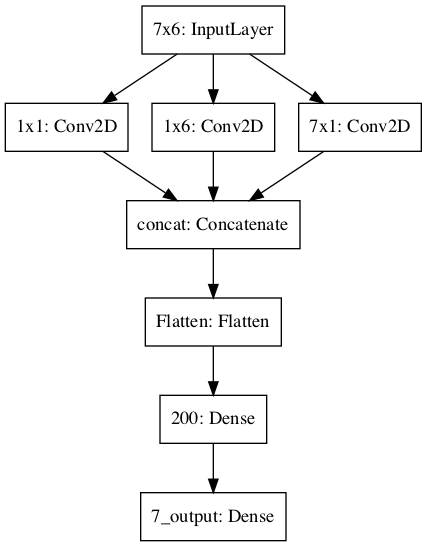

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(TrainNet.model, to_file='model.png')

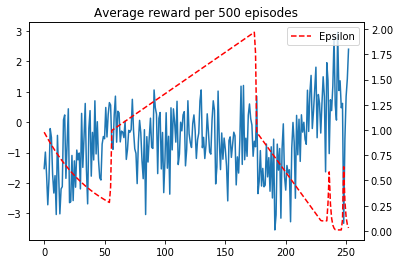

In [61]:
def ma(a, w):
    a = np.asarray(a)
    return np.mean(a[:(len(a)//w)*w].reshape(-1,w), axis=1)

m = 500
fig, ax = plt.subplots()
plt.plot(ma(all_total_rewards, m), label='Avg Reward')

# Get second axis
ax2 = ax.twinx()
plt.plot(ma(all_epsilons, m), '--r', label='Epsilon')
plt.title("Average reward per %d episodes" % m)
plt.legend()
plt.show()

# Evaluate our Agent
Here we define `my_agent`, this function polls our agent for its move given a specific game state. We pit our model against a completely random agent 300 times (half playing first, half playing second). We then also play Kaggle's implementation of a Negamax agent twice.

In [62]:
def my_agent(observation, configuration):
    return TrainNet.get_action(observation, 0)

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=150)))
print("Random Agent vs. My Agent:", 1-mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=150)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=1)))
print("Negamax Agent vs. My Agent:", 1-mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=1)))

My Agent vs. Random Agent: 0.62
Random Agent vs. My Agent: 0.5133333333333333
My Agent vs. Negamax Agent: 0.0
Negamax Agent vs. My Agent: 0.0


# Interpret the Agent

In [64]:
from kaggle_environments.envs.connectx.connectx import negamax_agent

def compute_gradients(observation, model, output=None, mode='default'):
    """
    Compute gradients for 'target' output.
    """
    data = np.atleast_2d(model.preprocess(observation))
     
    if mode=='smooth' or mode=='smooth+dot': # smoothgrad 50 samples
        data = data.astype('float64')
        for i in range(50):
            noise = np.random.normal(loc=0.0, scale=1, size=data.shape)
            data += noise
        data = data/50

    with tf.GradientTape() as tape:
        inputs = tf.cast(data, tf.float32)
        tape.watch(inputs)
        
        predictions = model.model(inputs)
        output = np.zeros(model.model.output.shape[1])
        output[np.argmax(predictions)] = 1
        
        l = tf.keras.losses.Huber()
        loss = l(output, predictions)
        
    if mode=='dot' or mode=='smooth+dot': # gradient • input
        gradients = tape.gradient(loss, inputs).numpy().flatten()
        inputs = np.asarray(observation.board)
        return gradients * inputs

    return tape.gradient(loss, inputs).numpy()


import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", cbar_true=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-0.01, vmax=0.01, **kwargs)

    # Create colorbar
    cbar=None
    if cbar_true:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, grads=None, valfmt="{x:.2f}", **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] == 0:
                text = " "
            elif data[i, j] == 1:
                text = im.axes.text(j, i, "O", fontsize=20, color='white', weight='bold', **kw)
            elif data[i, j] == 2:
                text = im.axes.text(j, i, "X", fontsize=20, color='black', weight='bold', **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def display_grad(gradients, board, ax=None, cbt=False, markers=True):
    grid = np.reshape(gradients, (6,7))
    board = np.reshape(np.asarray(board), (6,7))
    
    if ax == None:
        fig, ax = plt.subplots()
        cbt = True
        
    im, cbar = heatmap(grid, range(7), range(7), ax=ax, cmap="viridis", cbar_true=cbt)
    if markers:
        texts = annotate_heatmap(im, data=board, grads=grid, valfmt="{x:d}")
    
    #plt.show()

## Comparing Gradients, Gradients • Inputs, and SmoothGrad
Below is a visualisation of a board state. Our agent plays the **noughts** and the opponent is the **crosses**. The board state is imposed over the result of an interpretability technique that generates a saliency map - the background shows to what degree the state of each square affects the Agents choice of move. 

Our Agent will play its piece into column 1


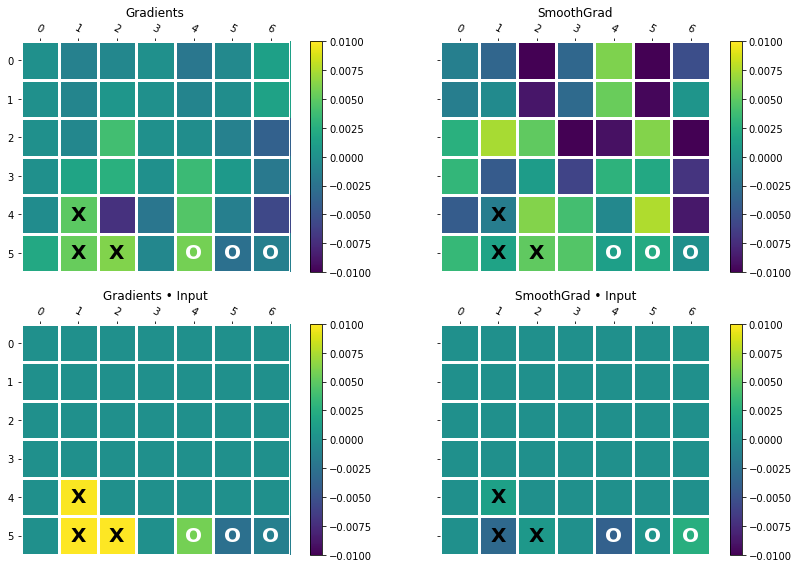

In [65]:
def ex_env():
    env = make("connectx")
    env.step([4, None])
    env.step([None, 1])
    env.step([5, None])
    env.step([None, 1])
    env.step([6, None])
    env.step([None, 2])
    return env

observation = ex_env().state[0].observation
choice = TrainNet.get_action(observation, 0)
print("Our Agent will play its piece into column %d" % choice)

fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
display_grad(compute_gradients(observation, TrainNet, mode='default'), observation.board, ax1[0], cbt=True)
ax1[0].set_title("Gradients")
display_grad(compute_gradients(observation, TrainNet, mode='smooth'), observation.board, ax1[1], cbt=True)
ax1[1].set_title("SmoothGrad")
display_grad(compute_gradients(observation, TrainNet, mode='dot'), observation.board, ax2[0], cbt=True)
ax2[0].set_title("Gradients • Input")
display_grad(compute_gradients(observation, TrainNet, mode='smooth+dot'), observation.board, ax2[1], cbt=True)
ax2[1].set_title("SmoothGrad • Input")
fig.tight_layout()
plt.show()

The Agent sees each of it's own pieces as *1*, the opponents as *-1* and empty squares as *0*. This causes problems for SmoothGrad and Gradients • Input.  
# Watch the Grandmaster Think
Below I visualise the Agent playing itself, 


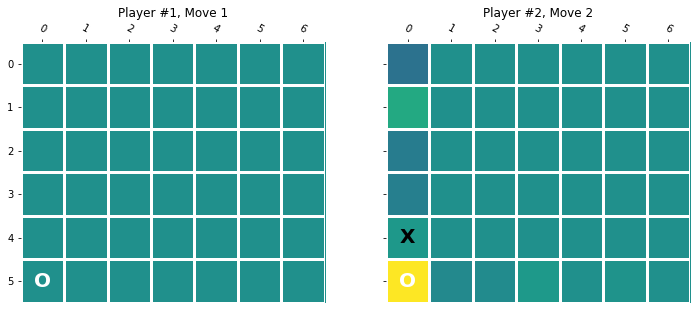

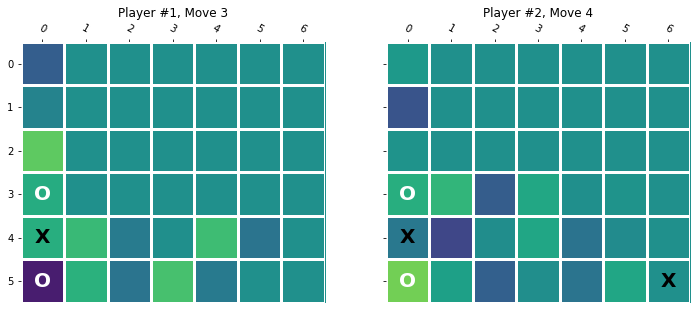

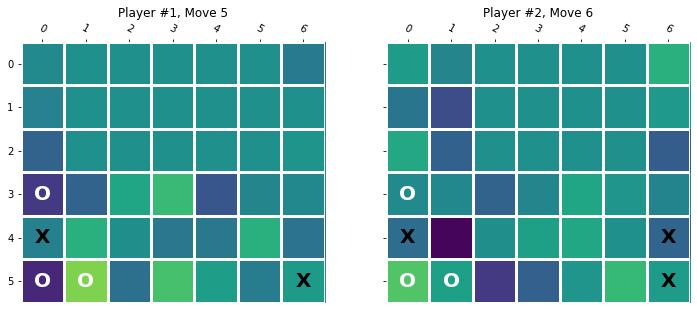

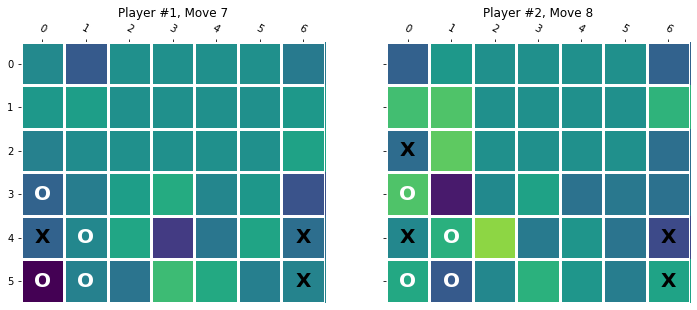

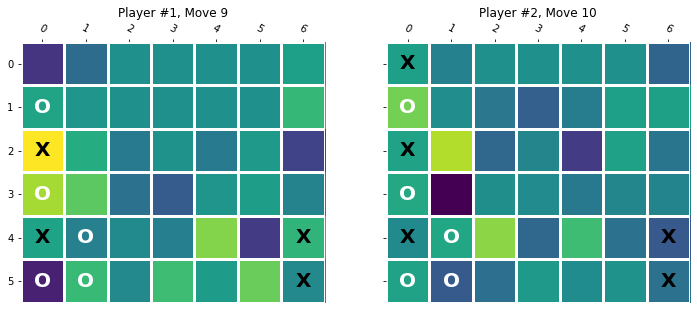

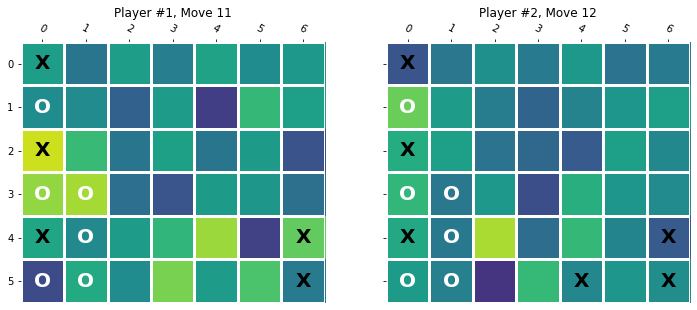

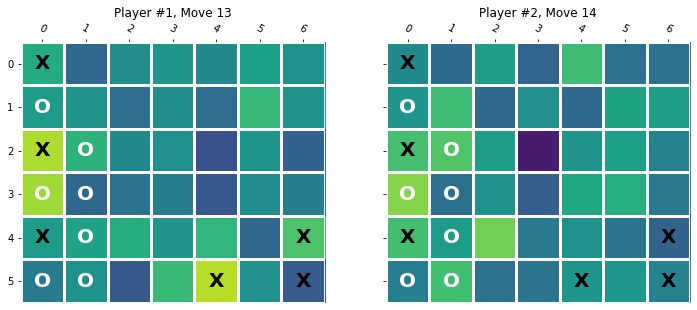

In [68]:
env = make("connectx", debug=True, configuration={'timeout':10000})
env.reset()
configuration = env.configuration
move = 0

while not env.done:
    move += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    
    ##### player 1
    observation   = env.state[0].observation
    choice = my_agent(observation, configuration)
    if not env.done: env.step([choice, None])
    display_grad(compute_gradients(observation, TrainNet, mode=''), env.state[0].observation.board, ax=ax1)
    ax1.set_title("Player #1, Move " + str(move))
        
    move += 1
    
    ##### player 2
    observation   = env.state[1].observation
    choice = my_agent(observation, configuration)
    if not env.done: env.step([None, choice])
    display_grad(compute_gradients(observation, TrainNet, mode=''), env.state[1].observation.board, ax=ax2)
    ax2.set_title("Player #2, Move " + str(move))
        
    plt.show()

In [69]:
def thinking_agent(observation, configuration):
    #display_grad(compute_gradients(observation, env.configuration, TrainNet), observation.board)
    return TrainNet.get_action(observation, 0)

env.play([None, thinking_agent])

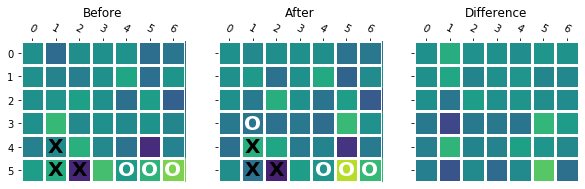

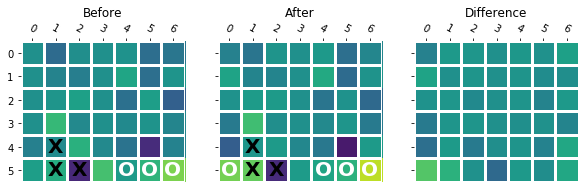

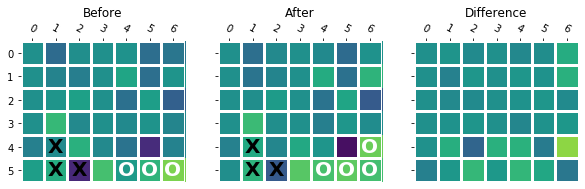

In [70]:
def analyse_move(env, net, choice=None, agent=1, player=0):
    observation = env.state[agent].observation
    
    fig, (a, b, c) =  plt.subplots(1, 3, sharey=True, figsize=(10,5))
    
    pre = compute_gradients(observation, net)
    display_grad(pre, observation.board, ax=a)
    a.set_title("Before")
    
    observation = env.state[player].observation
    if choice==None:
        choice = TrainNet.get_action(observation, 0)
        
    env.step([choice if i==player else None for i in [0,1]])
    
    observation = env.state[agent].observation
    post = compute_gradients(observation, net)
    
    display_grad(post, observation.board, ax=b)
    b.set_title("After")
    
    display_grad(post-pre, observation.board, ax=c, markers=False)
    c.set_title("Difference")
    
    plt.show()


analyse_move(ex_env(), TrainNet)
analyse_move(ex_env(), TrainNet, choice=0)
analyse_move(ex_env(), TrainNet, choice=6)